# Explore Absolut Data

We obtain the complete Absolut data. In this notebook, we explore it.

Of interest, based on the Readme:
- `RawBindingsMurine/`: the main database
    - `UniqueCDR3s.txt`: murine CDRH3 sequences that have been used (reference to paper), **not found**.
    - `XXXX_X.zip`: optimal binding of each 11-mer from each CDRH3 to this antigen
- `RawBindingsPerClassMurine/`: filtered w/ affinity
    - `XXXX_XAnalyses/`: filtered sequences to antigen XXXX_X
        - CDRH3-based top sequences
        - **11-mer based top sequences**: th defined using CDRH3, but contains multiple 11-mers from the same CDRH3 if they satisfy the threshold

Then there are processed datasets (had been used in Robert 2021 biorxiv):
- `Datasets1/`: binary classification per antigen
- `Datasets2/`: as above, but harder.
- `Datasets3/`: multi-class classification for subsets of N antigens
    - `nonRedundant_11mer-based/`: 142 non-redundant antigens. Includes:
        - binding profile: each bottom 1% CDRH3 to each antigen
- `Datasets4_Paratope_Epitope/`: includes encodings, such as degree-explicit/free, motiv, aggregate, chemical,
- `DatasetsAdditional/`: includes variations of others.

Q&A:
1. Why 11-mer?
2. What are the source unique CDR3s?
    - CDRH3 sequences of murine naive B cells.
3. What have been we using until now in terms of data?
    - top **70k best binders** for 10 different antigens.
        - best binders is probably meant by energy
        - not clear how much this covers in terms of %, since the distribution might be different across antigens.
    - the associated FeaturesFile includes paratope/epitope info.
    - Mat also send the 7M dataset, that included many more Slides, and `Best` col indicates which Slide yielded best binding from all Slides from a CDRH3 source.
4. What has been done on sequence encoding: degree-explicit/free; motif/aggregate/chemical encodings; gapped-motifs encodings;

In [1]:
from pathlib import Path
from itertools import combinations
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from typing import List

from NegativeClassOptimization import config
from NegativeClassOptimization import utils
from NegativeClassOptimization import preprocessing
from NegativeClassOptimization import datasets

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Building multiclass datasets for many antigens

We leverage `Datasets3/` for building multiclass datasets. From Readme:
- `Treated142.txt` => Binding profile of each bottom 1% CDRH3 to each antigen (column) => 142 columns
- `ListAntigens142.txt` => name/meaning of columns of Treated142.txt in this order
- Task2Annotated_142_nonredundant.zip => annotation of each sequence with the status "non-binder (top 99%)" or which antigens it bind if binder (bottom 1%). This was used to generate Treated142.txt, provided for information.

In [2]:
antigens = datasets.AbsolutDataset3.get_antigens()
print(f"{antigens[:5]=}")

df = datasets.AbsolutDataset3.get_binding_matrix()
df.head()

antigens[:5]=['1ADQ_A', '1FBI_X', '1FNS_A', '1FSK_A', '1H0D_C']


,Slide,num_binding_ags,binding_profile
0,AAAFITTVVPF,1,0000000000000000000000000000000000000010000000...
1,AAAGWLLLFDY,2,0000000000000100000000000000000000000000000000...
2,AAAIYWYFDVW,3,0000000000000010000010000000000000000010000000...
3,AAALLRSWFAY,1,0000000000000000000000000000000000000010000000...
4,AAALLRYPFAY,3,0001000000000000000000000000000000000010000000...


How many antigens binds a Slide on average?

df["num_binding_ags"].describe()=count    1.286631e+06
mean     5.902470e+00
std      9.812375e+00
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      6.000000e+00
max      1.110000e+02
Name: num_binding_ags, dtype: float64
df["num_binding_ags"].value_counts(normalize=True).head(10)=1     0.432816
2     0.142812
3     0.077307
4     0.051771
5     0.037965
6     0.029740
7     0.023767
8     0.019575
9     0.016290
10    0.014086
Name: num_binding_ags, dtype: float64


<AxesSubplot: >

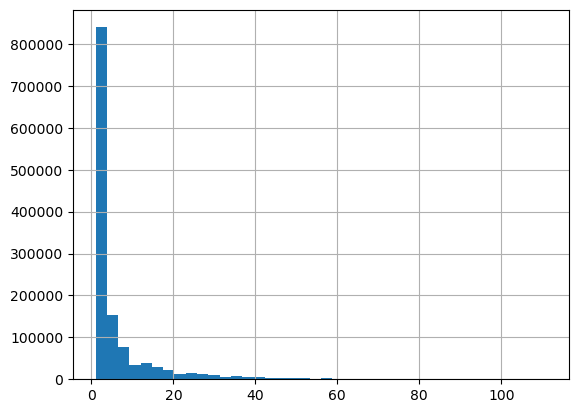

In [3]:
print(f'{df["num_binding_ags"].describe()=}')
print(f'{df["num_binding_ags"].value_counts(normalize=True).head(10)=}')
df["num_binding_ags"].hist(bins=40)

### Process

In [5]:
# df_wide = datasets.AbsolutDataset3.convert_to_wide_format(df, antigens)
# df_wide.head()

In [ ]:
ag_c, ag_o = antigens[:80], antigens[80:]

In [ ]:
mask_c = (df_wide[ag_c].sum(axis=1) >= 1) & (df_wide[ag_o].sum(axis=1) == 0)
mask_o = (df_wide[ag_c].sum(axis=1) == 0) & (df_wide[ag_o].sum(axis=1) >= 1)

print(f'{mask_c.sum()=} | {mask_o.sum()=}')

mask_c.sum()=446791 | mask_o.sum()=245900


In [ ]:
mask_unimodal = df_wide.sum(axis=1) == 1
print(f'{mask_unimodal.sum()=}')
print(f'{(mask_unimodal & mask_c).sum()=} | {(mask_unimodal & mask_o).sum()=}')

mask_unimodal.sum()=556875
(mask_unimodal & mask_c).sum()=347644 | (mask_unimodal & mask_o).sum()=209231


### Adaptor to internal multiclass classification

We need to adapt the new data to the format currently used for multiclass classification (`script/script_08*.py`). For that, we need to generate a `dfs` dictionary.

We generate these and save under `Absolut/processed/multiclass`.

In [ ]:
df_global = preprocessing.convert_wide_to_global(df_wide)
print(df_global.shape)
df_global.head()

(7594301, 3)


,Slide,Antigen,Slide_farmhash_mod_10
66,AAFITTVGWYF,1ADQ_A,5
116,AAFYGRWYFDV,1ADQ_A,9
124,AAFYYGNLAWF,1ADQ_A,2
204,AAGWLLLFAYW,1ADQ_A,3
205,AAGWLLLFDYW,1ADQ_A,9


In [ ]:
num_closed_ags = config.NUM_CLOSED_ANTIGENS_ABSOLUT_DATASET3
ags_shuffled = utils.shuffle_antigens(antigens)
ags_closed = ags_shuffled[:num_closed_ags]
ags_open = ags_shuffled[num_closed_ags:]

dfs_tuple = preprocessing.openset_datasplit_from_global_stable(
    df_global=df_global,
    openset_antigens=ags_open,
)

dfs = {
    "df_train_val": dfs_tuple[0],
    "df_test_closed_exclusive": dfs_tuple[1],
    "df_test_open_exclusive": dfs_tuple[2],
}

metadata = {
    "df_train_val__shape": dfs_tuple[0].shape,
    "df_test_closed_exclusive__shape": dfs_tuple[1].shape,
    "df_test_open_exclusive__shape": dfs_tuple[2].shape,
}

### Adaptor to internal multilabel classification

We generate processed dataset from Absolut for multilabel problems.

We basically need to generate dataframes for train, test, open, with some requirements:
- No `Slide` in open should be in closed (train / test)
- No `Slide` in test should be in training
- `Slide` should be one-hot encoded and farmhash % 10 column added

Developed further in notebook 17.

## Build ag sets

For evaluating open set performance for multiclass classifiers, we construct sets of antigens in a systematic way.

In [ ]:
ds3 = datasets.AbsolutDataset3()
antigens = ds3.antigens[:]

In [ ]:
ag_set_sizes = [5, 10, 20, 40, 80, 100]
ban_list = []
ag_sets_chain_1 = utils.generate_ag_set_chain(antigens, ag_set_sizes)
ban_list.append(ag_sets_chain_1[0])
ag_sets_chain_2 = utils.generate_ag_set_chain(antigens, ag_set_sizes, seed_ban_list=ban_list)
ban_list.append(ag_sets_chain_2[0])
# ag_sets_chain_1, ag_sets_chain_2

In [ ]:
from NegativeClassOptimization import pipelines


dfs = pipelines.MulticlassPipeline.load_processed_dataframes(
    dir_path = config.DATA_ABSOLUT_PROCESSED_MULTICLASS_DIR,
)

df_train = dfs["train_val"]
df_test = dfs["test_closed_exclusive"]
print(f"{df_train.shape=} | {df_test.shape=}")

df_train.shape=(351035, 4) | df_test.shape=(39016, 4)


(df_train["Antigen"].value_counts() > 1000).sum()=57


count       57.000000
mean      6158.508772
std       5679.702476
min       1013.000000
25%       2217.000000
50%       4223.000000
75%       7436.000000
max      24145.000000
Name: Antigen, dtype: float64

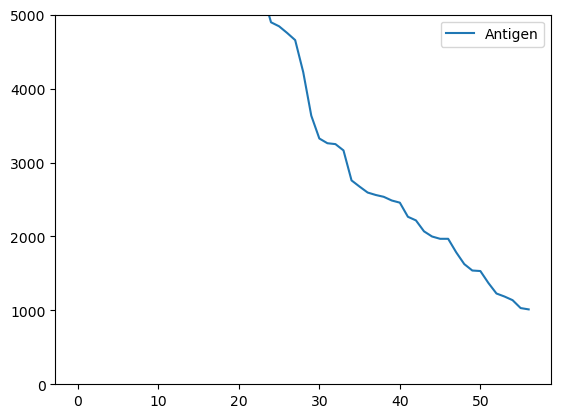

In [ ]:
df_train["Antigen"].value_counts().reset_index().plot(ylim=(0, 5000))
print(f'{(df_train["Antigen"].value_counts() > 1000).sum()=}')
df_train["Antigen"].value_counts().describe()

(df_test["Antigen"].value_counts() > 100).sum()=57


count      57.000000
mean      684.491228
std       635.793265
min       107.000000
25%       239.000000
50%       487.000000
75%       818.000000
max      2647.000000
Name: Antigen, dtype: float64

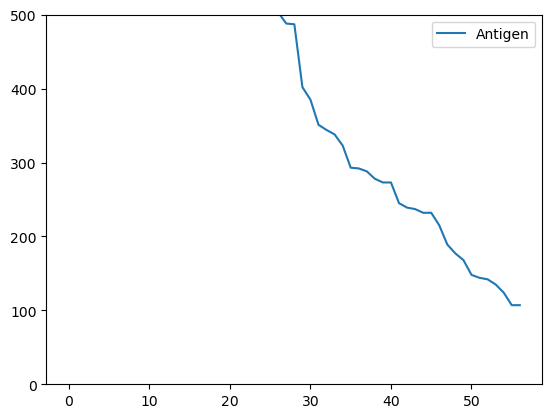

In [ ]:
df_test["Antigen"].value_counts().reset_index().plot(ylim=(0, 500))
print(f'{(df_test["Antigen"].value_counts() > 100).sum()=}')
df_test["Antigen"].value_counts().describe()

## Binding matrix structure

We need to understand the structure of the binding matrix for evaluating impact on the open set setting.

In [ ]:
df = ds3.df_wide

slide_order = ds3.df.sort_values(by="binding_profile", key=lambda x: x.str.count("1"), ascending=False)["Slide"]
df = df.loc[slide_order]
df = df.reindex(sorted(df.columns, key=lambda col: -df[col].sum()), axis=1)

df.head(2)

,1QFW_AB,5HI4_B,2WUC_I,5J13_A,2FD6_AU,3GI9_C,4OKV_E,4U6V_A,4DKE_A,1JPS_T,...,3SQO_A,5JZ7_A,2R56_A,4CAD_C,2UZI_R,5HDQ_A,2VXT_I,3JBQ_B,1NCB_N,1RJL_C
Slide,,,,,,,,,,,,,,,,,,,,,
LLVLLLLRWVF,1,1,0,0,1,1,1,1,0,1,...,1,0,1,1,0,1,1,1,1,1
PLLLLLLYWYF,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,0,1,0,1,1,1


In [ ]:
# sns.heatmap(df, cmap="Greys", cbar=False)

## NDB1 Asymmetry from Absolut

We generate datasets for binary classification for evaluating the impact of switching + and - Ag on closed/open set performance.

Setup: 10k vs 10k → evaluate closed and open set performance
- 10 random pairs
- 5 train/test splits
- 5 replicates per split
- 2 runs (switch Ag+ with Ag-)
- => 500 runs

We save the farmhash split such that we can later use it to deterministically split.

In [ ]:
ags_closed = ds3.df_wide.columns.to_list()
builder = pipelines.NDB1_Assymetry_from_Absolut_Builder(ags_closed, ds3)
builder.step_01_select_random_pairs()
builder.step_02_convert_to_global_format()

## Getting binding profiles
- Probably at `RawBindingsPerClassMurine/`: filtered w/ affinity
    - `XXXX_XAnalyses/`: filtered sequences to antigen XXXX_X
        - CDRH3-based top sequences
        - **11-mer based top sequences**: th defined using CDRH3, but contains multiple 11-mers from the same CDRH3 if they satisfy the threshold

Internally, we define:
- high_95low: non-binder CDR3s of the same antigen 
    - 0-1% vs 5%-100%
- high_looser: low affinity CDR3s of the same antigen 
    - 0-1% vs 1-5%

**NOTE:** Now we have functions to compute this. Check BinaryclassBindersPipeline.

In [2]:
# ag_path = Path("../data/Absolut/data/RawBindingsMurine/unzipped/1ADQ_A/1ADQ_A")

df = pd.read_csv(
    Path("../data/Absolut/data/RawBindingsMurine/unzipped/1ADQ_A/1ADQ_A/1ADQ_AFinalBindings_Process_1_Of_32.txt"),
    header=1,
    sep="\t",
)
print(df.shape)
df.head()

(980062, 6)


,ID_slide_Variant,CDR3,Best?,Slide,Energy,Structure
0,1_00a,CAGPSTTVPYYFDYW,False,CAGPSTTVPYY,-70.09,132966-BDUDDRDURR
1,1_01a,CAGPSTTVPYYFDYW,False,AGPSTTVPYYF,-77.71,132966-BDUDDRDURR
2,1_02a,CAGPSTTVPYYFDYW,False,GPSTTVPYYFD,-74.03,132965-DDUULULDDS
3,1_03a,CAGPSTTVPYYFDYW,True,PSTTVPYYFDY,-78.32,132966-BDSRRLUUSL
4,1_04a,CAGPSTTVPYYFDYW,False,STTVPYYFDYW,-73.95,132966-BDUDDRDURR


<AxesSubplot: xlabel='Energy', ylabel='Count'>

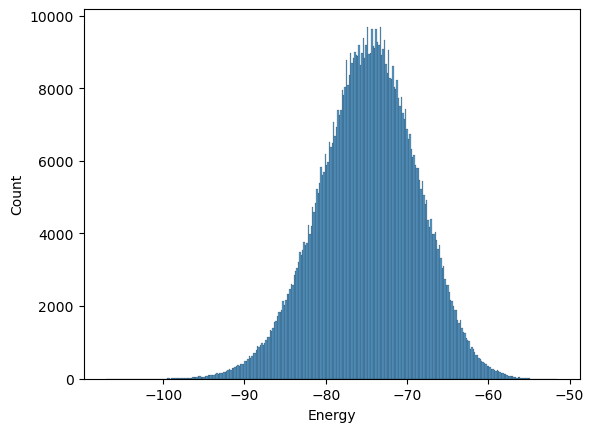

In [3]:
sns.histplot(
    df.groupby(["Slide"])["Energy"].agg("min")
)

In [7]:
ag = "1ADQ"
df = utils.load_raw_bindings_murine(ag)
df.shape

<AxesSubplot: xlabel='Energy', ylabel='Count'>

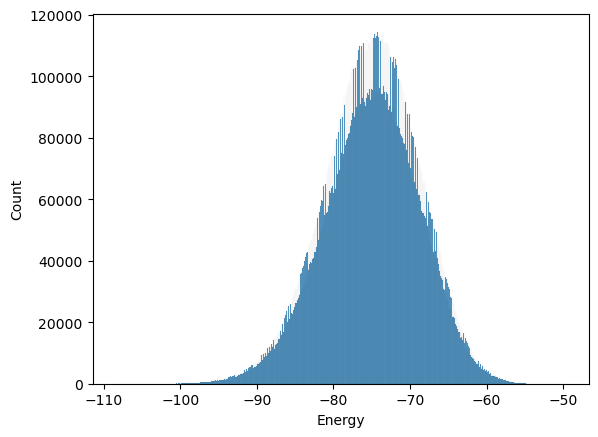

In [29]:
sns.histplot(
    df["Energy"]
)